# Programming Assignment: A Pneumonia Diagnostic Assistant

Congratulations on developing a strong skill set in PyTorch and Lightning! You have learned how to construct neural networks and optimize training pipelines. This assignment is your opportunity to channel that expertise into a project with real world significance.

The true power of artificial intelligence is demonstrated when it is applied to solve complex, meaningful problems. In this assignment, you will begin your journey into the impactful field of medical AI by building a tool to assist clinicians with pneumonia diagnosis. Your mission is to engineer the core deep learning engine for an AI powered diagnostic assistant. This is a direct application of the professional grade skills you have been developing, challenging you to build a solution that is not only accurate but also robust and well structured.

Throughout this programming assignment, you will:

* Assemble a `LightningDataModule` to create a clean and reusable data pipeline.
* Build a `LightningModule` to encapsulate your model, loss function, and training logic.
* Configure a Lightning `Trainer` with callbacks to run an efficient training loop.
* Evaluate your model's performance to understand its predictive capabilities.

You will develop a model that can analyze chest X-ray images and classify them as **Normal**, **Bacterial Pneumonia**, or **Viral Pneumonia**. This classification is an essential task, as a quick and accurate diagnosis can lead to better patient outcomes.

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

## Table of Contents
- [Imports](#0)
- [1 - Chest X-Ray Images](#1)
    - [1.1 - Dataset Preparation](#1-1)
    - [1.2 - Data Structure](#1-2)
    - [1.3 - The Visual Challenge: Differentiating Pneumonia Types](#1-3)
- [2 - Building the DataModule](#2)
    - [2.1 - Utilities for the DataModule](#2-1)
    - [2.2 - Assembling the ChestXRayDataModule](#2-2)
        - **[Exercise 1 - ChestXRayDataModule](#ex-1)**
- [3 - Building the LightningModule](#3)
    - [3.1 - Utilities for the LightningModule](#3-1)
    - [3.2 - Assembling the ChestXRayClassifier](#3-2)
        - **[Exercise 2 - ChestXRayClassifier](#ex-2)**
- [4 - Training the Model](#4)
    - [4.1 - Configuring Early Stopping](#4-1)
        - **[Exercise 3 - early_stopping](#ex-3)**
    - [4.2 - Configuring the Trainer](#4-2)
        - **[Exercise 4 - run_training](#ex-4)**
    - [4.3 - Training Your Diagnostic Assistant](#4-3)
- [5 - Evaluating Model Performance](#5)
    - [5.1 - Confusion Matrix and Per-Class Accuracy](#5-1)
    - [5.2 - Visualizing Predictions](#5-2)
    - [5.3 - A True Test](#5-3)

<a name='0'></a>
## Imports

In [1]:
import sys
import warnings

# Redirect stderr to a black hole to catch other potential messages
class BlackHole:
    def write(self, message):
        pass
    def flush(self):
        pass
sys.stderr = BlackHole()

# Ignore Python-level UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import os

import lightning.pytorch as pl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from lightning.pytorch.callbacks import EarlyStopping
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy
from torchvision import datasets, transforms
from torchvision import models as tv_models

torch.set_float32_matmul_precision('medium')

In [3]:
import matplotlib.pyplot as plt

import helper_utils
import unittests

<a name='1'></a>
## 1 - Chest X-Ray Images

An effective medical AI model is built upon a foundation of high-quality, relevant data. For your assignment, you will work with the [Chest X-Ray Images (Pneumonia) dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), a valuable collection of medical imagery. This dataset consists of chest X-ray images sourced from retrospective studies of pediatric patients aged one to five years at the Guangzhou Women and Children’s Medical Center. To ensure diagnostic quality, every image was evaluated and graded by two medical experts before its inclusion.

<a name='1-1'></a>
### 1.1 - Dataset Preparation

To tailor the data for your diagnostic tool, a few important modifications were made. The original dataset was organized into `train`, `test`, and `val` folders. To streamline the evaluation process, the `test` and `val` sets were combined into a single validation set for you to use.

More importantly, this assignment presents you with a nuanced, multiclass problem. The original dataset only identified images as `NORMAL` or `PNEUMONIA`. In the version you will use, the `PNEUMONIA` class has been split into two distinct categories: `BACTERIAL_PNEUMONIA` and `VIRAL_PNEUMONIA`. This change provides a more detailed diagnostic task, allowing your model to learn the subtle differences between the two types of infection.

Finally, preventing model bias is an essential part of building a fair and reliable medical tool. For that reason, the dataset was **balanced**. Images from the more frequent classes were randomly removed until every class in the training and validation sets contained the exact same number of images.

* Begin with defining the path to the dataset.

In [4]:
data_dir = "./chest_xray/"

<a name='1-2'></a>
### 1.2 - Data Structure

The data is organized into `train` and `val` directories, with subdirectories for each of the three classes. You will see the following structure:

```
./chest_xray/
│
├── train/
│   ├── NORMAL/
│   │   ├── IM-0001-0001.jpeg
│   │   └── ...
│   │
│   ├── BACTERIAL_PNEUMONIA/
│   │   ├── person1_bacteria_1.jpeg
│   │   └── ...
│   │
│   └── VIRAL_PNEUMONIA/
│       ├── person140_virus_284.jpeg
│       └── ...
│
└── val/
    ├── NORMAL/
    │   ├── IM-0001-0001.jpeg
    │   └── ...
    │
    ├── BACTERIAL_PNEUMONIA/
    │   ├── person1946_bacteria_4874.jpeg
    │   └── ...
    │
    └── VIRAL_PNEUMONIA/
        ├── person16_virus_44.jpeg
        └── ...
```

* Run the cell below to confirm the distribution of images across all classes in both the training and validation sets is balanced.

In [5]:
helper_utils.display_dataset_count(data_dir)

--- Train Set ---
  - BACTERIAL_PNEUMONIA      : 1338 images
  - NORMAL                   : 1338 images
  - VIRAL_PNEUMONIA          : 1338 images
——————————————————————————————————————————————————
  Total:                      4014 images

--- Val Set ---
  - BACTERIAL_PNEUMONIA      : 148 images
  - NORMAL                   : 148 images
  - VIRAL_PNEUMONIA          : 148 images
——————————————————————————————————————————————————
  Total:                       444 images



<a name='1-3'></a>
### 1.3 - The Visual Challenge: Differentiating Pneumonia Types

To appreciate the challenge your model is undertaking, it's helpful to recognize the general visual patterns associated with each class. Think of a chest X-ray as a picture where dense materials like bone appear white, and air-filled spaces like healthy lungs look dark. An infection can cause parts of the lungs to fill with fluid, making them look hazy or white.

Keep in mind that these are simplified observations for this assignment; a definitive diagnosis requires the skill of a trained medical expert.

* A **Normal** chest X-ray generally shows lungs that are clear and dark, indicating they are properly filled with air. You can typically see the sharp outlines of the heart, diaphragm, and rib cage.

* **Bacterial Pneumonia** often presents as a dense, white, or cloudy patch that is more localized to a specific area of the lung, sometimes called a "consolidation".

* In comparison, **Viral Pneumonia** tends to look more widespread and scattered. The pattern is often a more diffuse, hazy, or streaky whiteness that can be seen throughout both lungs.

Run the cell below to visualize some random examples from the training dataset and see these patterns for yourself.

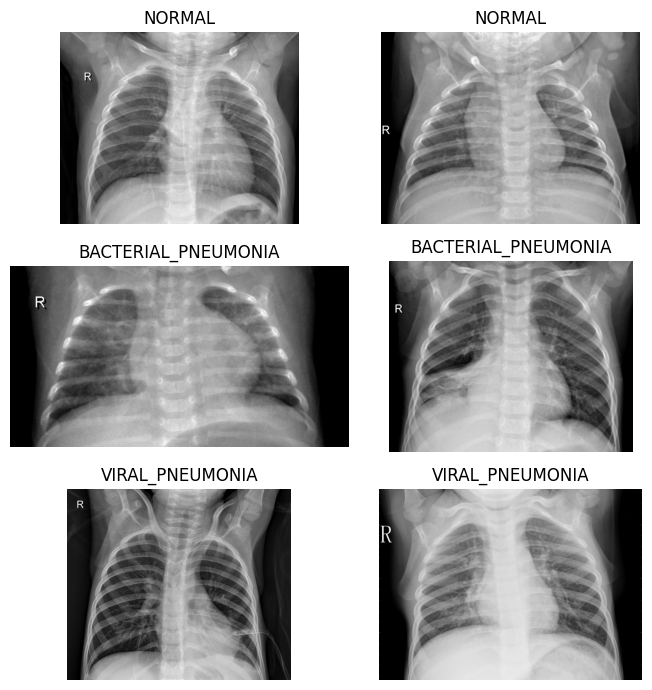

In [6]:
# Display a grid of random images from the training set to visualize the data.
helper_utils.display_random_images(data_dir + "train")

<a name='2'></a>
## 2 - Building the `DataModule`

You have already seen how Lightning simplifies the data handling process. You will now use its `DataModule` to manage everything related to the dataset for this assignment. Your first exercise ahead is to piece together the `ChestXRayDataModule`.

Before you build the module, you will first define the essential components, or "utilities," that your `DataModule` will use.

<a name='2-1'></a>
### 2.1 - Utilities for the `DataModule`

The code cells below contain the pre-written transformation pipelines and helper functions needed for your `DataModule`. Review each one carefully to understand its role.

* `TRAIN_TRANSFORM` and `VAL_TRANSFORM`: These are the `torchvision` transform pipelines. The training pipeline includes data augmentation to help your model generalize, while the validation pipeline performs only the necessary preprocessing for evaluation.

In [7]:
# Define the series of transformations to be applied to the training images.
TRAIN_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # Perform a random affine transformation: shifting and scaling the image.
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    # Normalize the tensor image with a precalculated mean and standard deviation
    # of this dataset.
    transforms.Normalize([0.482, 0.482, 0.482], [0.222, 0.222, 0.222])
])

# Define the transformations for the validation images.
VAL_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalize the tensor image with a precalculated mean and standard deviation
    # of this dataset.
    transforms.Normalize([0.482, 0.482, 0.482], [0.222, 0.222, 0.222])
])

* `create_datasets(…)`: This function takes file paths and transforms as input and returns the initialized training and validation `ImageFolder` datasets.

In [8]:
def create_datasets(train_path, val_path, train_transform, val_transform):
    """
    Creates and returns the necessary datasets for training and validation.

    Args:
        train_path (str): The file path to the training images.
        val_path (str): The file path to the validation images.
        train_transform (callable): Transformations to apply to the training data.
        val_transform (callable): Transformations to apply to the validation data.

    Returns:
        A tuple containing the train_dataset and val_dataset.
    """
    # Create the training and validation datasets from the image folders.
    train_dataset = datasets.ImageFolder(train_path, train_transform)
    val_dataset = datasets.ImageFolder(val_path, val_transform)

    return train_dataset, val_dataset

* `load_dataloader(…)`: This function takes the datasets and other parameters to create and return *either* a training *or* validation `DataLoader`.

In [9]:
def load_dataloader(train_dataset, val_dataset, batch_size, is_train_loader):
    """
    Creates and returns either a training or validation DataLoader.

   Args:
        train_dataset (Dataset): The dataset for the training loader.
        val_dataset (Dataset): The dataset for the validation loader.
        batch_size (int): The number of samples per batch to load.
        is_train_loader (bool): A flag to determine which loader to create.
                                If True, creates the training loader.
                                If False, creates the validation loader.

    Returns:
        DataLoader: The configured PyTorch DataLoader.
    """
    # Check the flag to determine whether to create a training or validation loader.
    if is_train_loader==True:
        # Create the training DataLoader.
        loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )
    
    else:
        # Create the validation DataLoader.
        loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False
        )
        
    return loader

<a name='2-2'></a>
### 2.2 - Assembling the `ChestXRayDataModule`

You have now defined all the necessary utilities for your data pipeline. You are at the final assembly stage, where you will bring these components together inside a `LightningDataModule`.

The `DataModule` acts as the organizational backbone for your entire data pipeline. It encapsulates all data related logic, from loading and splitting to transforming and batching, into a single, reusable class. This practice keeps your main model code clean and ensures your data handling is reproducible, which is essential for any medical AI application.

<a name='ex-1'></a>
### Exercise 1 - ChestXRayDataModule

Your exercise is to complete the `ChestXRayDataModule` using the utilities you have just reviewed.

**Your Task**:

* **Inside the `__init__` method**: 
>    * This is the setup method for your `DataModule`. You need to store the `data_dir` and `batch_size` that are passed in.
>    * You also need to assign the pre-defined transform pipelines, `TRAIN_TRANSFORM` and `VAL_TRANSFORM`, to instance attributes so they can be accessed by other methods in the class.

* **Inside the `setup` method**: 
>    * This method is responsible for creating the datasets. You'll use the `create_datasets` helper function to initialize `self.train_dataset` and `self.val_dataset`.
>    * Make sure you pass the correct arguments to the function, including the paths and the transforms you stored earlier.

* **Inside the `train_dataloader` and `val_dataloader` methods**: 
>    * These methods create the data loaders that will feed batches of data to your model.
>    * You'll need to call the `load_dataloader` helper function in each method. Pay close attention to the `is_train_loader` flag to ensure you create the correct type of loader (one for training, one for validation).

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you're stuck, here is a more detailed breakdown.

**For the `__init__` method**:

* You're simply saving the arguments passed to the constructor.
* For example, the first line will be `self.data_dir = data_dir`. Follow this exact pattern for `batch_size`, `train_transform`, and `val_transform`.

**For the `setup` method**:

* You need to call the `create_datasets` function and assign its two outputs to `self.train_dataset` and `self.val_dataset`.
* The function call should look like this:
    > `self.train_dataset, self.val_dataset = call create_datasets(using the train_path, val_path, self.train_transform, and self.val_transform as arguments)`

**For the `train_dataloader` method**:

* Call the `load_dataloader` function. The key is to tell it you want a *training* loader.
* The call will look like this:
    > `train_loader = load_dataloader(with self.train_dataset, self.val_dataset, self.batch_size, and the is_train_loader flag set to True)`

**For the `val_dataloader` method**:

* This is very similar to the training loader, but you must indicate that you want a *validation* loader.
* The call will look like this:
    > `val_loader = load_dataloader(with self.train_dataset, self.val_dataset, self.batch_size, and the is_train_loader flag set to False)`

</details>

In [30]:
# GRADED CLASS: ChestXRayDataModule

class ChestXRayDataModule(pl.LightningDataModule):
    """
    A LightningDataModule encapsulates all the steps involved in preparing data
    for a PyTorch model.
    """

    def __init__(self, data_dir, batch_size=64):
        """
        Initializes the DataModule and stores key parameters.

        Args:
            data_dir (str): Directory where the data is stored.
            batch_size (int): Number of samples per batch in the DataLoader.
        """
        super().__init__()
        
        ### START CODE HERE ###
        
        # Store the constructor arguments as instance attributes.
        self.data_dir = data_dir
        self.batch_size = batch_size
        
        # Assign the globally defined transformations to this instance.
        self.train_transform = TRAIN_TRANSFORM
        self.val_transform = VAL_TRANSFORM
        
        ### END CODE HERE ###
        
        # DO NOT REMOVE `NONE` OF THESE PLACEHOLDERS
        # Placeholders for datasets, to be assigned in setup().
        self.train_dataset = None
        self.val_dataset = None

    def setup(self, stage=None):
        """
        Assigns the train and validation datasets.

        Args:
        stage (str, optional): The stage of training (e.g., 'fit', 'test').
                               The Lightning Trainer requires this argument, but it is not
                               utilized in this implementation as the setup logic is the
                               same for all stages. Defaults to None.
        """
        # Construct the full paths to the train and validation image folders.
        train_path = os.path.join(self.data_dir, "train")
        val_path = os.path.join(self.data_dir, "val")
        
        ### START CODE HERE ###
        
        # Call the `create_datasets` helper function with the correct of the
        # arguments to initialize self.train_dataset and self.val_dataset.
        self.train_dataset, self.val_dataset = create_datasets(train_path, val_path, self.train_transform, self.val_transform)
        ### END CODE HERE ###

    def train_dataloader(self):
        """Returns the DataLoader for the training set."""
        
        ### START CODE HERE ###
        
        # Call the `load_dataloader` helper function to create the
        # training loader.
        train_loader = load_dataloader(self.train_dataset, self.val_dataset, self.batch_size, is_train_loader=True) 
        
        ### END CODE HERE ###
        
        return train_loader

    def val_dataloader(self):
        """Returns the DataLoader for the validation set."""
        
        ### START CODE HERE ###
        
        # Call the `load_dataloader` helper function to create the
        # validation loader.
        val_loader = load_dataloader(self.train_dataset, self.val_dataset, self.batch_size, is_train_loader=False) 
        
        ### END CODE HERE ###
        
        return val_loader

In [31]:
# Instantiate the DataModule for verification.
dm_verify = ChestXRayDataModule(data_dir=data_dir, batch_size=8)
# Set up the datasets.
dm_verify.setup()
train_loader_verify = dm_verify.train_dataloader()
val_loader_verify = dm_verify.val_dataloader()

# --- Verify the Training Set ---
print("--- Training Set ---")
print(f"Total samples in the training dataset:    {len(dm_verify.train_dataset)}")
print(f"DataLoader batch size:                    {train_loader_verify.batch_size}")
print(f"DataLoader length (number of batches):    {len(train_loader_verify)}")

# --- Verify the Validation Set ---
print("\n--- Validation Set ---")
print(f"Total samples in the validation dataset:  {len(dm_verify.val_dataset)}")
print(f"DataLoader batch size:                    {val_loader_verify.batch_size}")
print(f"DataLoader length (number of batches):    {len(val_loader_verify)}")

--- Training Set ---
Total samples in the training dataset:    4014
DataLoader batch size:                    8
DataLoader length (number of batches):    502

--- Validation Set ---
Total samples in the validation dataset:  444
DataLoader batch size:                    8
DataLoader length (number of batches):    56


#### Expected Output:

```
--- Training Set ---
Total samples in the training dataset:    4014
DataLoader batch size:                    8
DataLoader length (number of batches):    502

--- Validation Set ---
Total samples in the validation dataset:  444
DataLoader batch size:                    8
DataLoader length (number of batches):    56
```

In [32]:
# Test your code!
unittests.exercise_1(ChestXRayDataModule)

 All tests passed!


<a name='3'></a>
## 3 - Building the `LightningModule`

With the data pipeline complete, your next task is to construct the `ChestXRayClassifier`, which is a `LightningModule`. This class is the core of your AI model; it organizes all the essential components for training, including the model architecture, the loss function, and the optimizers, into a single, self contained system.

Just like before, you will first review the pre-written utilities that your `LightningModule` will use to function.

<a name='3-1'></a>
### 3.1 - Utilities for the `LightningModule`

The helper functions below are designed to handle model initialization and optimizer configuration. Review each one to understand its specific role before using them in the main exercise.

* `load_resnet18(…)`: This function initializes a ResNet-18 model and prepares it for transfer learning. It replaces the final classification layer with a new one suited for your three-class problem and freezes all other layers. This ensures you are only training the new head on top of the powerful, pre-trained features.

In [33]:
def load_resnet18(num_classes, weights_path):
    """
    Initializes a ResNet-18 model, loads weights, and sets it up
    for transfer learning (feature extraction).

    Args:
        num_classes (int): The number of output classes for the new classifier head.
        weights_path (str): The file path to the saved .pth model weights.

    Returns:
        A PyTorch model (ResNet-18) where all layers are frozen except for
        the final classifier head.
    """
    # Initialize a ResNet-18 model without pre-trained weights.
    model = tv_models.resnet18(weights=None)

    # Replace the classifier head to match the number of classes for the new task.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Load the state dictionary (weights) from the local file.
    state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)

    # Freeze all the parameters in the model.
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze ONLY the parameters of the new classifier head.
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

* `define_optimizer_and_scheduler(…)`: This function returns the `AdamW` optimizer and a `ReduceLROnPlateau` learning rate scheduler. The scheduler will automatically reduce the learning rate if the validation loss stops improving, which is a common technique for effective training.

In [34]:
def define_optimizer_and_scheduler(model, learning_rate, weight_decay):
    """
    Defines the optimizer and learning rate scheduler for the model.

    Args:
        model (nn.Module): The model for which to configure the optimizer.
                           Its parameters will be passed to the optimizer.
        learning_rate (float): The learning rate for the optimizer.
        weight_decay (float): The weight decay (L2 penalty) for the optimizer.

    Returns:
        A tuple containing the configured optimizer and lr_scheduler.
    """
    # Create the optimizer.
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    
    # Create the learning rate scheduler.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=2
    )
    
    return optimizer, scheduler

<a name='3-2'></a>
### 3.2 - Assembling the `ChestXRayClassifier`

You've now reached the heart of the assignment: assembling the `ChestXRayClassifier`. This is where you will define the complete system for your diagnostic model.

The `LightningModule` is the central command center for your model. It brings together the neural network architecture (your pre-trained ResNet-18), the loss function for measuring error, the metrics for tracking performance, and the optimizers that drive the learning process. By organizing these components into a single class, you create a clean, portable, and highly structured system, a hallmark of professional deep learning engineering.

<a name='ex-2'></a>
### Exercise 2 - ChestXRayClassifier

Your exercise is to complete the `ChestXRayClassifier` using the utilities you have just reviewed.

**Your Task**:

* **Inside the `__init__` method**: 
>    * This method sets up the core components of your classifier.
>    * You need to initialize the pre-trained model by calling the `load_resnet18` helper function.
>    * Define the loss function. For this multi-class classification problem, `nn.CrossEntropyLoss` is the right choice.
>    * Define the accuracy metric using `Accuracy`. Remember to configure it for a "multiclass" task.

* **Inside the `training_step` method**: 
>    * This method defines the logic for a single forward pass and loss calculation during training.
>    * First, unpack the input `batch` into images and their corresponding labels.
>    * Next, get the model's raw predictions (`logits`) by performing a forward pass on the images.
>    * Finally, compute the training loss by comparing the model's logits with the true labels.

* **Inside the `validation_step` method**: 
>    * This method is similar to `training_step` but is used for the validation loop.
>    * You'll unpack the `batch`, get the `logits`, and calculate the `loss` in the same way.
>    * You also need to calculate the `accuracy` for the validation batch using the metric you defined in `__init__`.

* **Inside the `configure_optimizers` method**: 
>    * This method sets up the optimizer and learning rate scheduler for the training process.
>    * You will call the `define_optimizer_and_scheduler` helper function to get the configured optimizer and scheduler.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you're stuck, here is a more detailed breakdown.

**For the `__init__` method**:

* To load the model, you'll call the provided helper function:
    > `self.model = load_resnet18(with num_classes from self.hparams, and weights_path from self.hparams)`
* Instantiating the loss function is a direct call with no arguments:
    > `self.loss_fn = instantiate nn.CrossEntropyLoss()`
* For the accuracy metric, you need to provide the task type and number of classes:
    > `self.accuracy = instantiate Accuracy(with the task set to "multiclass", and num_classes from self.hparams)`

**For the `training_step` method**:

* Unpacking the batch is straightforward: `x, y = batch`.
* A forward pass is done by calling the instance itself on the input tensor: `logits = self(x)`
* Calculate the loss by passing the predictions and true labels to your loss function:
    > `loss = self.loss_fn(logits, y)`

**For the `validation_step` method**:

* The first three steps are identical to the `training_step`.
* To calculate accuracy, you'll use the accuracy object you created, passing it the same logits and labels:
    > `acc = self.accuracy(logits, y)`

**For the `configure_optimizers` method**:

* You need to call the helper function and capture its two outputs.
* The function call should look like this:
    > `optimizer, scheduler = call define_optimizer_and_scheduler(passing self.model, and the learning_rate and weight_decay from self.hparams)`

</details>

In [44]:
# GRADED CLASS: ChestXRayClassifier

class ChestXRayClassifier(pl.LightningModule):
    """A LightningModule that is focused on tracking validation loss and accuracy."""

    def __init__(self, model_weights_path, num_classes=3, learning_rate=1e-3, weight_decay=1e-2):
        """
        Initializes the ChestXRayClassifier module.

        Args:
            model_weights_path (str): The file path to the pre-trained ResNet-18 model weights.
            num_classes (int): The number of classes for classification. Defaults to 3.
            learning_rate (float): The learning rate for the optimizer. Defaults to 1e-3.
            weight_decay (float): The weight decay (L2 penalty) for the optimizer. Defaults to 1e-2.
        """
        super().__init__()
        # Save all __init__ arguments (model_weights_path, num_classes, etc.) to self.hparams
        # For example, you’ll access `num_classes` as `self.hparams.num_classes`
        self.save_hyperparameters()
        
        ### START CODE HERE ###

        # Call the `load_resnet18` helper function to get the pre-trained model.
        self.model = load_resnet18(
            num_classes,
            model_weights_path
        ) 
        
        # Define the Cross Entropy loss function.
        self.loss_fn = nn.CrossEntropyLoss()
        
        # Define the accuracy metric using `Accuracy`.
        # Remember to specify the task and the number of classes.
        self.accuracy = Accuracy(
            task="multiclass",
            num_classes=num_classes
        )
        
        ### END CODE HERE ###

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): The input tensor of images.
        """
        return self.model(x)

    def training_step(self, batch, batch_idx=None):
        """
        Performs a single training step. Loss calculation is required for backpropagation.

        Args:
        batch (tuple): A tuple containing the input images and their labels.
        batch_idx (int): The index of the current batch. The Lightning Trainer
                         requires this argument, but it's not utilized in this
                         implementation as the logic is the same for all batches.
        """
        
        ### START CODE HERE ###
        
        # Unpack the batch into images and labels.
        x, y = batch
        # Perform a forward pass to get the model's logits.
        logits = self.forward(x)
        # Calculate the loss by comparing the logits to the true labels.
        loss = self.loss_fn(logits, y)
        
        ### END CODE HERE ###
        
        return loss

    def validation_step(self, batch, batch_idx=None):
        """
        Performs a single validation step and logs only the loss and accuracy.

        Args:
        batch (tuple): A tuple containing the input images and their labels.
        batch_idx (int): The index of the current batch. The Lightning Trainer
                         requires this argument, but it's not utilized in this
                         implementation as the logic is the same for all batches.
        """
        
        ### START CODE HERE ###
        
        # Unpack the batch into images and labels.
        x, y = batch
        # Perform a forward pass to get the model's logits.
        logits = self.forward(x)
         # Calculate the loss.
        loss = self.loss_fn(logits, y)
        # Calculate the accuracy.
        acc = self.accuracy(logits, y)
        
         ### END CODE HERE ###
        
        # Log metrics for this validation epoch and show them in the progress bar.
        self.log_dict({'val_loss': loss, 'val_acc': acc}, prog_bar=True)

    def configure_optimizers(self):
        """Configures the optimizers and learning rate scheduler."""
        
        ### START CODE HERE ###
        
        # Call the `define_optimizer_and_scheduler` helper function.
        optimizer, scheduler = define_optimizer_and_scheduler(
            self.model,
            self.hparams.learning_rate,
            self.hparams.weight_decay
        ) 
        
         ### END CODE HERE ###
        
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}

In [45]:
# Instantiate the classifier for verification.
weights_path = helper_utils.setup_dummy_weights()
verify_model = ChestXRayClassifier(model_weights_path=weights_path)

# Get the optimizer and scheduler.
optimizer_config = verify_model.configure_optimizers()
optimizer = optimizer_config["optimizer"]
scheduler = optimizer_config["lr_scheduler"]["scheduler"]

# --- Print the results to verify ---
print("--- LightningModule Components ---")
print(f"Model Architecture: {verify_model.model.__class__.__name__}")
print(f"Classifier Head:    {verify_model.model.fc}")
print(f"Loss Function:      {verify_model.loss_fn.__class__.__name__}")
print(f"Accuracy Metric:    {verify_model.accuracy.__class__.__name__}(num_classes={verify_model.accuracy.num_classes})")
print(f"Optimizer:          {optimizer.__class__.__name__}")
print(f"LR Scheduler:       {scheduler.__class__.__name__}")
# Clean dummy weights
helper_utils.cleanup_dummy_weights()

--- LightningModule Components ---
Model Architecture: ResNet
Classifier Head:    Linear(in_features=512, out_features=3, bias=True)
Loss Function:      CrossEntropyLoss
Accuracy Metric:    MulticlassAccuracy(num_classes=3)
Optimizer:          AdamW
LR Scheduler:       ReduceLROnPlateau


#### Expected Output

```
--- LightningModule Components ---
Model Architecture: ResNet
Classifier Head:    Linear(in_features=512, out_features=3, bias=True)
Loss Function:      CrossEntropyLoss
Accuracy Metric:    MulticlassAccuracy(num_classes=3)
Optimizer:          AdamW
LR Scheduler:       ReduceLROnPlateau
```

In [46]:
# Test your code!
unittests.exercise_2(ChestXRayClassifier)

 All tests passed!


<a name='4'></a>
## 4 - Training the Model

You have successfully prepared the data and assembled the model. The final step is to configure and run the training process. For this purpose, you will set up a callback for efficient training and the trainer.

<a name='4-1'></a>
### 4.1 - Configuring Early Stopping

Training a model for too long can lead to overfitting, while stopping too soon can result in an undertrained model. A common technique to find the right balance is **early stopping**.

Lightning's [EarlyStopping](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.EarlyStopping.html) callback monitors a specific metric and automatically stops the training process once a desired performance threshold is met. This ensures you train just long enough to achieve your goal without wasting computational resources.

<a name='ex-3'></a>
### Exercise 3 - early_stopping

Your exercise is to configure the `EarlyStopping` callback to intelligently manage your training duration.

**Your Task**:

* **Instantiate the `EarlyStopping` callback**:
>
    * You need to create an instance of the `EarlyStopping` class with the correct parameters.
>    
    * `monitor`: Specify the metric to track. For this assignment, you'll monitor the validation accuracy, which is logged as `"val_acc"`.
>    
    * `stopping_threshold`: Set the `stop_threshold` value for the monitored metric. The training will stop once this value is reached.
>    
    * `patience`: Define the number of epochs to wait for an improvement in `val_acc`. If the accuracy doesn't improve for this many consecutive epochs, training will stop. You should set this to **half** of the total `num_epochs`. Remember, patience must be an **integer**.
>    
    * `mode`: Tell the callback whether it should look for an increase or decrease in the monitored metric. Since a higher validation accuracy is better, you should set this to `"max"`.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you're stuck, here is a more detailed breakdown.

**For instantiating the `EarlyStopping` callback**:

You are filling in the arguments for a single function call. The pseudo-code for the complete instantiation looks like this:
```
    stop = EarlyStopping(
        monitor is set to the string 'val_acc',
        stopping_threshold is set to the stop_threshold function argument,
        patience is set to half of the num_epochs converted to an integer,
        mode is set to the string 'max'
        )
```

</details>

In [47]:
# GRADED FUNCTION: early_stopping

def early_stopping(num_epochs, stop_threshold):
    """
    Configures and returns a Lightning EarlyStopping callback.

    Args:
        num_epochs (int): The maximum number of epochs, used to set patience.
        stop_threshold (float): The validation accuracy threshold to stop training.

    Returns:
        EarlyStopping: The configured Lightning callback.
    """
    
    ### START CODE HERE ###
    
    # Instantiate the EarlyStopping callback.
    stop = EarlyStopping(
        # Specify the metric to monitor as validation accuracy.
        monitor='val_acc',
        
        # Set the value that the monitored metric must reach to stop training.
        stopping_threshold=stop_threshold,
        
        # Set patience to half of the total epochs. 
        # HINT: Use type casting to ensure the value is an integer.
        patience=num_epochs // 2,
        
        # Set the mode to "max" because a higher accuracy is better.
        mode="max"
    ) 
    
    ### END CODE HERE ###
    
    return stop

In [48]:
# Define sample parameters for verification.
num_epochs_verify = 15
stop_threshold_verify = 0.90

# Call the function to create the callback.
verify_callback = early_stopping(num_epochs_verify, stop_threshold_verify)

# --- Print the results to verify ---
print("--- EarlyStopping Configuration ---")
print(f"Metric to Monitor:     {verify_callback.monitor}")
print(f"Stopping Threshold:    {verify_callback.stopping_threshold}")
print(f"Patience:              {verify_callback.patience}")
print(f"Mode:                  {verify_callback.mode}")

--- EarlyStopping Configuration ---
Metric to Monitor:     val_acc
Stopping Threshold:    0.9
Patience:              7
Mode:                  max


#### Expected Output:

```
--- EarlyStopping Configuration ---
Metric to Monitor:     val_acc
Stopping Threshold:    0.9
Patience:              7
Mode:                  max
```

In [49]:
# Test your code!
unittests.exercise_3(early_stopping)

 All tests passed!


<a name='4-2'></a>
### 4.2 - Configuring the Trainer

With your `DataModule`, `LightningModule`, and `EarlyStopping` callback ready, you can now configure the training process. The `pl.Trainer` is the engine that orchestrates the entire training loop, handling everything from hardware acceleration to callbacks automatically.

<a name='ex-4'></a>
### Exercise 4 - run_training

Your exercise is to configure the Lightning `Trainer` and use it to run the training process.

**Your Task**:

* **Instantiate the `pl.Trainer`**:
    * You need to complete the instantiation of the `Trainer` object.
    * Set the maximum number of training epochs to the `num_epochs` provided.
    * Enable **16-bit mixed-precision training** for faster computation.
    * Pass the `callback` to the `Trainer`. Note that the callbacks argument expects a list of callbacks.
* **Run the training**:
    * After configuring the `Trainer`, you must start the training loop.
    * Call the `.fit()` method on your trainer instance, passing it the `model` and `data_module`.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you're stuck, here is a more detailed breakdown.

**For instantiating the `pl.Trainer`**:

* You are filling in the arguments for the `pl.Trainer` constructor.
* The `max_epochs` argument should be set to the `num_epochs` variable.
* The precision argument should be the string `'16-mixed'`.
* The `callbacks` argument must be a list. The call will look like this:
    > `callbacks=[callback]`

**For running the training**:

* This is a method call on the `trainer` object you just created.
* The pseudo-code for this call is:
    > `call the fit method on the trainer, passing in the model and the data_module`

</details>

In [52]:
# GRADED FUNCTION: run_training

def run_training(model, data_module, num_epochs, callback, progress_bar=True, dry_run=False):
    """
    Configures and runs a Lightning mixed-precision training process.

    Args:
        model (pl.LightningModule): The model to be trained.
        data_module (pl.LightningDataModule): The data module that provides the datasets.
        num_epochs (int): The maximum number of epochs for training.
        callback (pl.Callback): A callback, such as for early stopping.
        progress_bar (bool): If True, shows the training progress bar. Defaults to True.
        dry_run (bool): If True, runs a quick single batch "dry run" to test the code.
                        Defaults to False.

    Returns:
        A tuple containing:
            - pl.Trainer: The trainer instance after fitting is complete.
            - pl.LightningModule: The trained model with updated weights.
    """
    
    ### START CODE HERE ###
    
    # Instantiate the PyTorch Lightning Trainer with specific configurations.
    trainer = pl.Trainer(
        # Set the maximum number of training epochs.
        max_epochs=num_epochs,
        
        # Automatically select the best hardware accelerator (GPU, CPU).
        accelerator="auto", 
        # Use a single device.
        devices=1, 
        
        # Enable 16-bit mixed-precision training to speed up computation.
        precision='16-mixed',
        # Add callback
        callbacks=[callback],
        
    ### END CODE HERE ###
        
        # Disable the default logger.
        logger=False,
        # Show the training progress bar.
        enable_progress_bar=progress_bar,
        # Disable the model summary printout
        enable_model_summary=False,
        # Disable automatic model checkpointing.
        enable_checkpointing=False,
        # fast_dev_run flag for test runs.
        fast_dev_run=dry_run
    )
    
    ### START CODE HERE ###
    
    # Run the training process.
    trainer.fit(model, data_module)
    
    ### END CODE HERE ###
    
    return trainer, model

In [53]:
# Set up the components for verification run.
verify_dm = ChestXRayDataModule(data_dir=data_dir, batch_size=2)
weights_path = helper_utils.setup_dummy_weights()
verify_model = ChestXRayClassifier(model_weights_path=weights_path)
num_epochs=1
verify_callback = early_stopping(num_epochs=num_epochs, stop_threshold=0.99)

# Call the run_training function with dry_run=True.
print("--- Verifying Training Run (Dry Run) ---")
run_training(
    model=verify_model, 
    data_module=verify_dm, 
    num_epochs=num_epochs, 
    callback=verify_callback,
    dry_run=True
)

print("The Trainer configured and ran a single batch without errors.")
# Clean dummy weights
helper_utils.cleanup_dummy_weights()

Output()

--- Verifying Training Run (Dry Run) ---


The Trainer configured and ran a single batch without errors.


#### Expected Output:

```
--- Verifying Training Run (Dry Run) ---
Epoch 0: 100% 1/1
The Trainer configured and ran a single batch without errors.
```

In [54]:
# Test your code!
unittests.exercise_4(run_training, ChestXRayDataModule, ChestXRayClassifier)

 All tests passed!


---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-techniques-and-ecosystem-tools/561).

---

<a name='4-3'></a>
### 4.3 - Training Your Diagnostic Assistant

You have now assembled and verified all the necessary components. This final code cell brings everything together to run the full training process.

Training a model for a task like this isn't a quick process; it requires a significant amount of time and computation. To save you from a lengthy training session, you are being provided with pre-trained weights for the ResNet-18 model backbone.

**How the Model Was Trained**

The setup used to train this model was nearly identical to the one in this assignment. The key difference was a two-stage training strategy, which you were introduced to in Module 2 of this course.

**Why a Two-Stage Strategy?**

The original ResNet-18 model was trained on general images (like photos of cats, dogs, and cars), not medical scans. While its core layers are excellent at detecting basic shapes and textures, they need to be adapted for the specific patterns found in X-rays. This two-stage approach provides a much faster turnaround with limited resources compared to training the entire model from scratch.

* **Feature Extraction**: First, only the new classifier head was trained for **10 epochs** with a learning rate of **1e-3**. This quickly teaches the final layer to make predictions based on the general features from the frozen ResNet backbone.

* **Fine-Tuning**: Simply training the classifier head isn't always enough. In this stage, the **last two convolutional blocks** (`layer3` and `layer4`) of the ResNet model were "unfrozen" and the entire model was trained for another **15 epochs** with a much smaller learning rate of **1e-5**. This carefully adjusts the pre-trained layers to become better at identifying pneumonia-specific patterns.

After this two-stage process, the model achieved a final validation accuracy of approximately **80%**.

* Run the cell below to define the path to these pre-trained model weights, which you will use to train the model's classifier head further.

In [55]:
# Define the file path for the pre-trained model weights.
pretrained_weights = "./resnet18_chest_xray_classifier_weights.pth"

These are the key hyperparameters for your training run. Feel free to experiment with different values, but start with these recommended numbers:

* Set the maximum number of training epochs to **10**.
* Define the target validation accuracy for early stopping as **85%**.

In [56]:
# EDITABLE CELL

# Set the maximum number of training cycles (epochs).
training_epochs = 10

# Define the validation accuracy threshold to stop training once reached.
target_accuracy = 0.85

* Create the `EarlyStopping` callback by calling your `early_stopping` function with the hyperparameters you just defined.

In [57]:
# Create the EarlyStopping callback by calling your function with the defined hyperparameters.
early_stopping_callback = early_stopping(training_epochs, target_accuracy)

* Instantiate your `ChestXRayDataModule` and `ChestXRayClassifier`.
* Call your `run_training` function with all the components to start the training process.

In [58]:
# Set the random seed to ensure the experiment is reproducible.
pl.seed_everything(15)

# Instantiate the DataModule to handle data loading and transformations.
dm = ChestXRayDataModule(data_dir)
dm.setup()

# Instantiate the LightningModule, passing in the path to the pre-trained weights.
model = ChestXRayClassifier(model_weights_path=pretrained_weights)

# Call the training function with all the components to start the training process.
trained_trainer, trained_model = run_training(
    model, dm, training_epochs, early_stopping_callback
)

# Print a message to confirm that the training has finished.
print("\n--- Training Complete ---")

Output()


--- Training Complete ---


<br>

Congratulations on training your model! The `Trainer` object keeps a record of the metrics from the training run.

* Run the cell below to access the final validation accuracy from your `trained_trainer` object and print the result.

In [59]:
# Get the final metrics from the trainer object
final_metrics = trained_trainer.callback_metrics

# Extract the validation accuracy and convert it to a number
final_val_acc = final_metrics["val_acc"].item()

# Print the final validation accuracy
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Final Validation Accuracy: 0.8514


<a name='5'></a>
## 5 - Evaluating Model Performance

Your model has been trained, and you have its final validation accuracy. Now, you will dive deeper to understand its performance on a more granular level. An overall accuracy score is useful, but it doesn't tell the whole story, especially in a medical context where the cost of misclassification can be high.

<a name='5-1'></a>
### 5.1 - Confusion Matrix and Per-Class Accuracy

To begin your analysis, you will generate a **confusion matrix**. This powerful tool will show not just how many predictions were correct, but also what kind of mistakes the model made (e.g., confusing Bacterial Pneumonia with Viral Pneumonia).

From this matrix, you will also calculate the **per-class accuracy**, which tells you how well the model performed on each individual class (`NORMAL`, `BACTERIAL_PNEUMONIA`, and `VIRAL_PNEUMONIA`).

Evaluating Model:   0%|          | 0/7 [00:00<?, ?it/s]

--- Per-Class Accuracy Report ---
  - Accuracy for class 'BACTERIAL_PNEUMONIA': 0.9392
  - Accuracy for class 'NORMAL': 0.8243
  - Accuracy for class 'VIRAL_PNEUMONIA': 0.7905



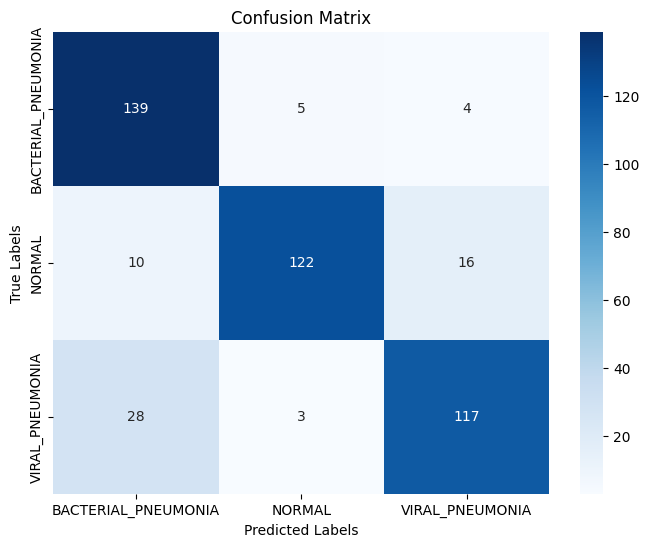

In [60]:
# Evaluate the trained model to display a per-class accuracy report and a confusion matrix.
helper_utils.per_class_acc_and_conf_matrix(trained_model, dm)

<a name='5-2'></a>
### 5.2 - Visualizing Predictions

Your analysis is more complete when you look at how your model performs on individual images. Take a look at some of the predictions your model makes on the validation set.

* Run the `display_random_predictions` function, which makes use of the validation dataset from the `dm` `DataModule`. Each execution will choose a random batch of images to display.

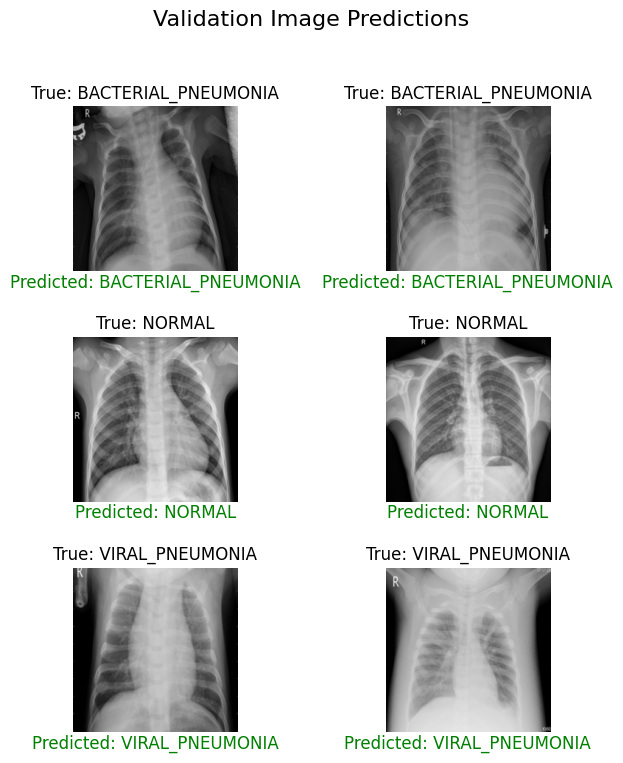

In [61]:
helper_utils.display_random_predictions(trained_model, dm)

<a name='5-3'></a>
### 5.3 - A True Test

Now, for a true test of your model’s predictions. Some images were removed from the original dataset and saved as a truly unseen group. This means your model has never had any exposure to these images during training or validation.

These images are available at the following paths:

* **BACTERIAL_PNEUMONIA**
    * "./unseen/BACTERIAL_PNEUMONIA/person296_bacteria_1394.jpeg" 
    * "./unseen/BACTERIAL_PNEUMONIA/person441_bacteria_1916.jpeg" 
    * "./unseen/BACTERIAL_PNEUMONIA/person564_bacteria_2342.jpeg" 
* **NORMAL**
    * "./unseen/NORMAL/IM-0353-0001.jpeg" 
    * "./unseen/NORMAL/IM-0633-0001.jpeg" 
    * "./unseen/NORMAL/NORMAL2-IM-0866-0001.jpeg" 
* **VIRAL_PNEUMONIA**
    * "./unseen/VIRAL_PNEUMONIA/person1369_virus_2356.jpeg" 
    * "./unseen/VIRAL_PNEUMONIA/person1465_virus_2537.jpeg" 
    * "./unseen/VIRAL_PNEUMONIA/person1537_virus_2674.jpeg" 

Use the `display_prediction` function to see how well your trained model performs on these images.

* Feel free to set the image_path to any one of these images.

In [62]:
# EDITABLE CELL

# Define the file path for the unseen image to be predicted.
image_path = "./unseen/BACTERIAL_PNEUMONIA/person296_bacteria_1394.jpeg"

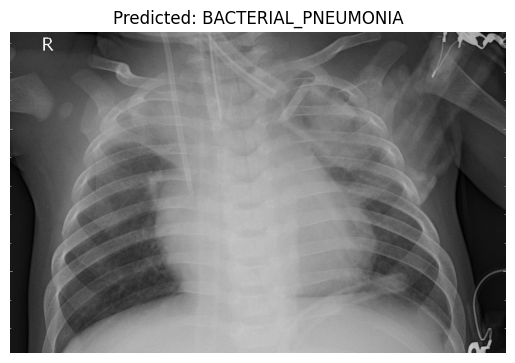

In [63]:
# Use the display_prediction function to show the image and its predicted class.
helper_utils.display_prediction(trained_model, dm, image_path)

## Conclusion

Excellent work on completing this assignment. You have successfully navigated the process of building a complete deep learning system for medical image analysis. By applying your knowledge of PyTorch and Lightning, you have engineered the core engine for a pneumonia diagnostic assistant, turning theoretical concepts into a practical and meaningful application.

You began this assignment with a mission to solve a real world problem, and you have accomplished that by creating a well organized and effective classifier. The skills you practiced here, especially structuring your project with the `DataModule` and `LightningModule`, are vital for building scalable and maintainable AI systems in any professional environment. You should be proud of the sophisticated tool you have built. Keep leveraging these skills to tackle new and exciting challenges.